<a href="https://colab.research.google.com/github/veronicadonelli/financial-risk-return-analysis/blob/main/Risk_Return_Analysis_Performance_Evaluation_of_Financial_Assets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('paper')

In [3]:
TICKERS = ["ENPH", "JPM", "NEE", "SCHW", "STNE", "XOM"]
BENCH = "^GSPC"
all_tickers = TICKERS + [BENCH]

In [10]:
import datetime
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
data = yf.download(all_tickers, start="2018-01-01", end=end_date)

if data.empty:
    print("No data is found")
else:
    print("Columns:")
    print(data.columns)

/tmp/ipython-input-3697166074.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(all_tickers, start="2018-01-01", end=end_date)
[*********************100%***********************]  7 of 7 completed

Columns:
MultiIndex([( 'Close',  'ENPH'),
            ( 'Close',   'JPM'),
            ( 'Close',   'NEE'),
            ( 'Close',  'SCHW'),
            ( 'Close',  'STNE'),
            ( 'Close',   'XOM'),
            ( 'Close', '^GSPC'),
            (  'High',  'ENPH'),
            (  'High',   'JPM'),
            (  'High',   'NEE'),
            (  'High',  'SCHW'),
            (  'High',  'STNE'),
            (  'High',   'XOM'),
            (  'High', '^GSPC'),
            (   'Low',  'ENPH'),
            (   'Low',   'JPM'),
            (   'Low',   'NEE'),
            (   'Low',  'SCHW'),
            (   'Low',  'STNE'),
            (   'Low',   'XOM'),
            (   'Low', '^GSPC'),
            (  'Open',  'ENPH'),
            (  'Open',   'JPM'),
            (  'Open',   'NEE'),
            (  'Open',  'SCHW'),
            (  'Open',  'STNE'),
            (  'Open',   'XOM'),
            (  'Open', '^GSPC'),
            ('Volume',  'ENPH'),
            ('Volume',   'JPM'),
 

In [11]:
price_level = data.columns.get_level_values(0)

print("\nHead of 'close':")
print(close.head())
print("\nColumns in 'close':")
print(close.columns)


Head of 'close':
Ticker      ENPH        JPM        NEE       SCHW  STNE        XOM  \
Date                                                                 
2018-01-02  2.60  87.152016  31.994001  46.286789   NaN  59.486694   
2018-01-03  2.58  87.240829  31.315300  46.358776   NaN  60.654999   
2018-01-04  2.50  88.490601  31.154387  46.619724   NaN  60.738968   
2018-01-05  2.47  87.922516  31.296747  46.799690   NaN  60.689960   
2018-01-08  2.41  88.052353  31.554613  47.006641   NaN  60.962811   

Ticker            ^GSPC  
Date                     
2018-01-02  2695.810059  
2018-01-03  2713.060059  
2018-01-04  2723.989990  
2018-01-05  2743.149902  
2018-01-08  2747.709961  

Columns in 'close':
Index(['ENPH', 'JPM', 'NEE', 'SCHW', 'STNE', 'XOM', '^GSPC'], dtype='object', name='Ticker')


In [12]:
rets = np.log(close / close.shift(1)).dropna()
print("Head of 'rets':")
print(rets.head())

Head of 'rets':
Ticker          ENPH       JPM       NEE      SCHW      STNE       XOM  \
Date                                                                     
2018-10-26 -0.048904 -0.013828 -0.019296  0.000231 -0.008328 -0.010010   
2018-10-29 -0.009592  0.013732  0.016868  0.011740 -0.067524 -0.006210   
2018-10-30  0.021455  0.017490  0.004446  0.041901 -0.013163  0.022204   
2018-10-31  0.068364  0.021510 -0.006069  0.014596  0.000349  0.011360   
2018-11-01  0.078347 -0.000367 -0.011838  0.003239  0.025126  0.012348   

Ticker         ^GSPC  
Date                  
2018-10-26 -0.017479  
2018-10-29 -0.006581  
2018-10-30  0.015545  
2018-10-31  0.010793  
2018-11-01  0.010502  


In [13]:
# Performance indicators

# A. Calculation of Annualized Sharpe Ratio
trading_days = 252
risk_free_rate_annual = 0.01  # assuming a 1% annual risk-free rate

# Calculate daily returns and volatility for the assets
mean_returns_daily = rets[TICKERS].mean()
std_returns_daily  = rets[TICKERS].std()

# Annualize returns and volatility:
annualized_mean_returns = mean_returns_daily * trading_days
annualized_std_returns  = std_returns_daily * np.sqrt(trading_days)

# Compute the annualized Sharpe Ratio for each asset
annualized_sharpe = (annualized_mean_returns - risk_free_rate_annual) / annualized_std_returns

print("\nAnnualized Sharpe Ratio for each asset:")
print(annualized_sharpe)


Annualized Sharpe Ratio for each asset:
Ticker
ENPH    0.391639
JPM     0.591018
NEE     0.335637
SCHW    0.329379
STNE   -0.121232
XOM     0.286231
dtype: float64


In [14]:
# B. Calculation of Beta relative to the benchmark
# Check if the benchmark is present in the returns DataFrame
if BENCH in rets.columns:
    bench_rets = rets[BENCH]
else:
    print(f"Warning: Benchmark ticker '{BENCH}' not found in 'rets' columns. Beta calculation will be skipped.")
    bench_rets = None

betas = {}
if bench_rets is not None:
    # Iterate over each ticker in the list of assets to analyze
    for ticker in TICKERS:
        # Concatenate the returns of the ticker and the benchmark, removing any NaN values
        combined = pd.concat([rets[ticker], bench_rets], axis=1).dropna()
        combined.columns = [ticker, 'Benchmark']
        # Check if there is enough data to perform a linear regression
        if len(combined) > 1:
            beta = linregress(combined['Benchmark'], combined[ticker]).slope
            betas[ticker] = beta
        else:
            print(f"Warning: insufficient data to calculate beta for {ticker}.")

print(f"\nBeta for each asset relative to the benchmark ({BENCH}):")
print(betas)


Beta for each asset relative to the benchmark (^GSPC):
{'ENPH': np.float64(1.5044888267105225), 'JPM': np.float64(1.064494469205587), 'NEE': np.float64(0.6991855998171962), 'SCHW': np.float64(1.0532232914478015), 'STNE': np.float64(1.7194902491179662), 'XOM': np.float64(0.8166450009100736)}


In [16]:
# C. Calculation of Value at Risk (VaR) at the 5% quantile
VaR = rets[TICKERS].quantile(0.05)
print("\nValue at Risk (al 5% quantile) per ogni titolo:")
print(VaR)


Value at Risk (al 5% quantile) per ogni titolo:
Ticker
ENPH   -0.066268
JPM    -0.027263
NEE    -0.025562
SCHW   -0.033567
STNE   -0.063483
XOM    -0.029921
Name: 0.05, dtype: float64


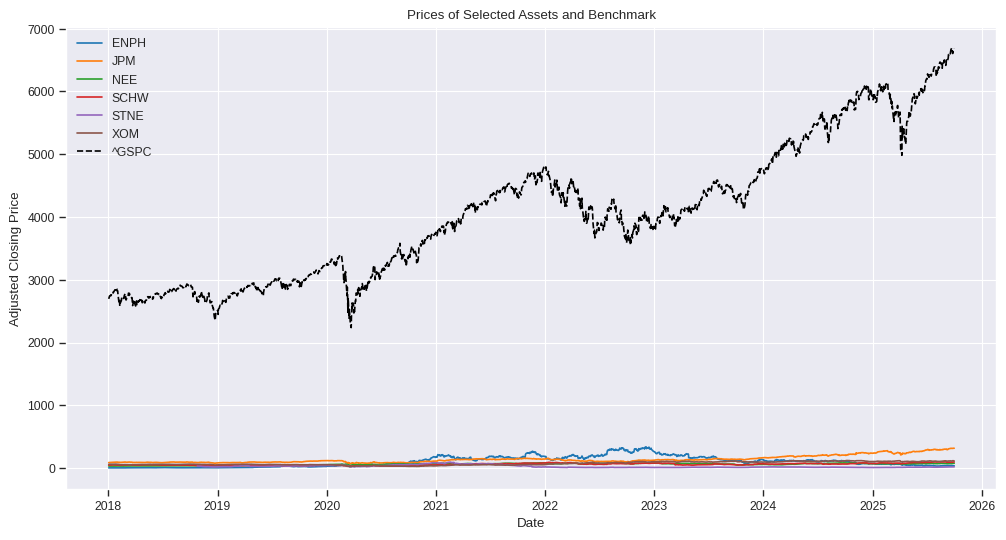

In [17]:
# Chart of closing prices
plt.figure(figsize=(12, 6))
for ticker in TICKERS:
    plt.plot(close[ticker], label=ticker)
plt.plot(close[BENCH], label=BENCH, linestyle='--', color='black')
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.title("Prices of Selected Assets and Benchmark")
plt.legend()
plt.savefig('closing_prices.pdf', dpi=300, bbox_inches='tight')
plt.show()


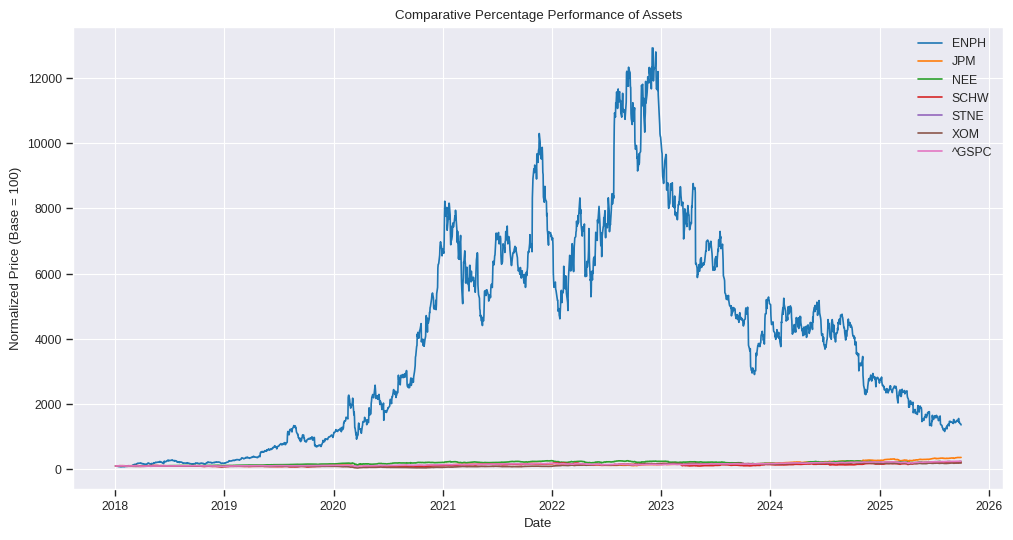

In [31]:
# Normalizing the data by setting the initial price to 100
close_normalized = close / close.iloc[0] * 100

# Chart of normalized prices
plt.figure(figsize=(12,6))
for ticker in close_normalized.columns:
    plt.plot(close_normalized.index, close_normalized[ticker], label=ticker)
plt.xlabel("Date")
plt.ylabel("Normalized Price (Base = 100)")
plt.title("Comparative Percentage Performance of Assets")
plt.legend()
plt.savefig('normalized_prices.pdf', dpi=300, bbox_inches='tight')
plt.show()


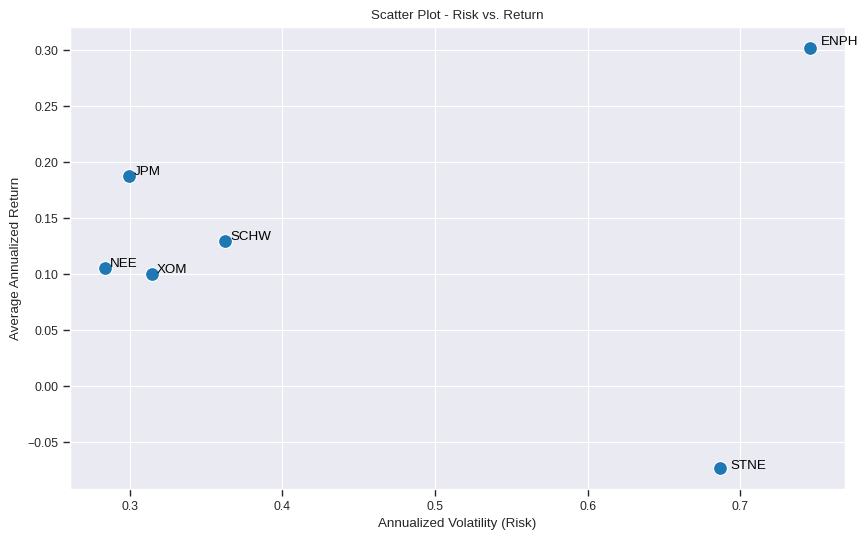

In [19]:
# Scatter plot of risk/return ratio (using annualized values)
plt.figure(figsize=(10,6))
sns.scatterplot(x=annualized_std_returns, y=annualized_mean_returns, s=100)

# Add annotations for each ticker
for ticker in tickers:
    plt.text(annualized_std_returns[ticker] * 1.01, annualized_mean_returns[ticker] * 1.01, ticker,
             horizontalalignment='left', size='medium', color='black')

plt.xlabel("Annualized Volatility (Risk)")
plt.ylabel("Average Annualized Return")
plt.title("Scatter Plot - Risk vs. Return")
plt.grid(True)
plt.savefig('risk_return_scatter.pdf', dpi=300, bbox_inches='tight')
plt.show()


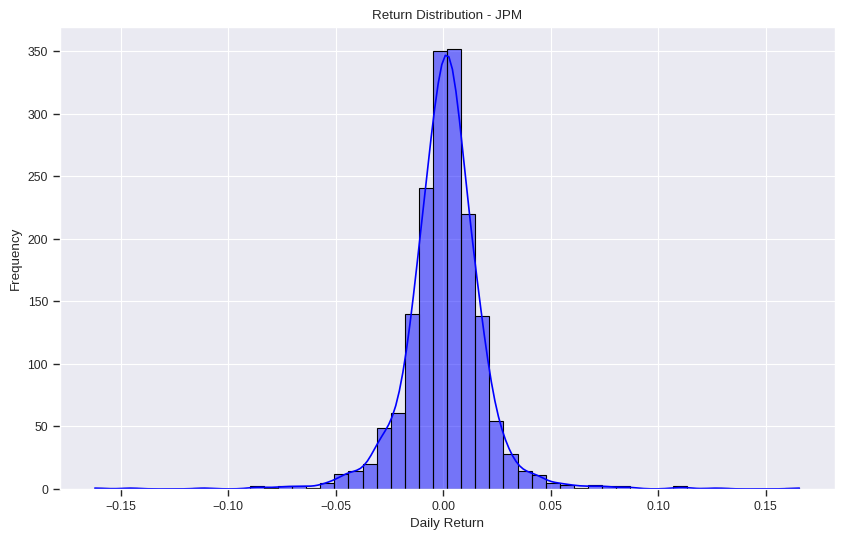

/tmp/ipython-input-903454256.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rets[ticker], label=ticker, shade=True)
/tmp/ipython-input-903454256.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rets[ticker], label=ticker, shade=True)
/tmp/ipython-input-903454256.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rets[ticker], label=ticker, shade=True)
/tmp/ipython-input-903454256.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rets[ticker], label=ticker, shade=True)
/tmp/ipython-inp

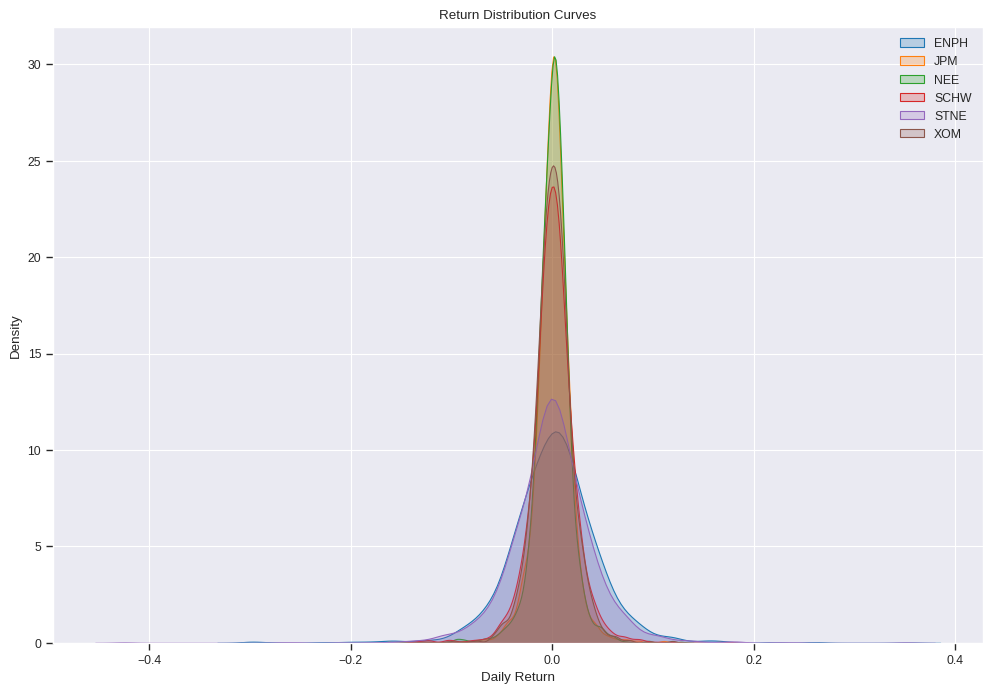

In [20]:
# Example: Return distribution for JPM
plt.figure(figsize=(10,6))
sns.histplot(rets['JPM'], kde=True, bins=50, color='blue')
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.title("Return Distribution - JPM")

# Save the plot
plt.savefig('return_distribution_jpm.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Multiple KDE curves in one plot
plt.figure(figsize=(12,8))
for ticker in tickers:
    sns.kdeplot(rets[ticker], label=ticker, shade=True)
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.title("Return Distribution Curves")
plt.legend()

# Save the plot
plt.savefig('return_distribution_multiple.pdf', dpi=300, bbox_inches='tight')
plt.show()


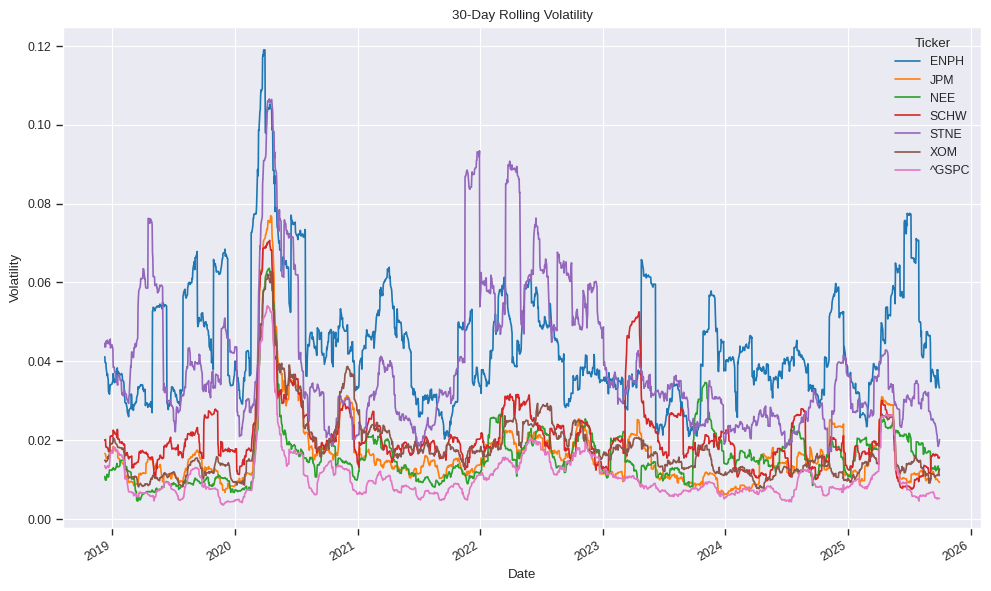

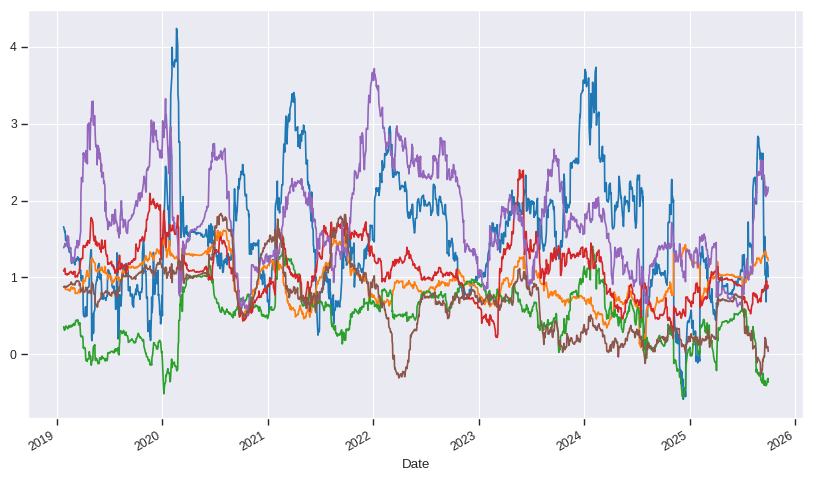

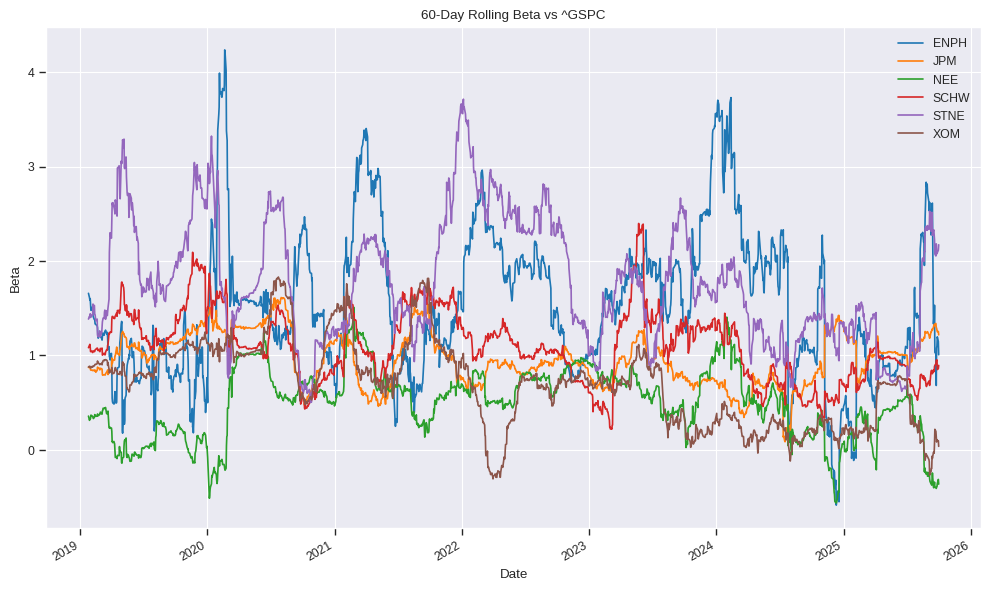

In [26]:
import statsmodels.api as sm

# === Rolling Volatility (30 giorni) ===
rolling_vol = rets.rolling(window=30).std()

ax = rolling_vol.plot(figsize=(10, 6))
ax.set_title("30-Day Rolling Volatility")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.grid(True)
plt.tight_layout()
plt.savefig("rolling_volatility.pdf", dpi=300)
plt.show()
plt.close()


# === Rolling Beta (60 giorni) ===
window = 60
rolling_beta = {}

if BENCH in rets.columns:
    bench_rets_series = rets[BENCH]

    for ticker in TICKERS:
        asset_rets_series = rets[ticker]
        combined_rolling = pd.concat([asset_rets_series, bench_rets_series], axis=1).dropna()
        combined_rolling.columns = ['asset', 'market']

        ticker_rolling_beta = []
        for i in range(len(combined_rolling) - window):
            y = combined_rolling['asset'].iloc[i:i+window]
            x = combined_rolling['market'].iloc[i:i+window]
            x = sm.add_constant(x)

            if len(x) > 1 and len(y) > 1:
                try:
                    model = sm.OLS(y, x).fit()
                    ticker_rolling_beta.append(model.params['market'])
                except ValueError:
                    ticker_rolling_beta.append(np.nan)
            else:
                ticker_rolling_beta.append(np.nan)

        rolling_beta[ticker] = pd.Series(ticker_rolling_beta, index=combined_rolling.index[window:])

    fig, ax = plt.subplots(figsize=(10, 6))
for ticker, beta_series in rolling_beta.items():
    beta_series.plot(ax=ax, label=ticker)

fig, ax = plt.subplots(figsize=(10, 6))
for ticker, beta_series in rolling_beta.items():
    beta_series.plot(ax=ax, label=ticker)

ax.set_title(f"60-Day Rolling Beta vs {BENCH}")
ax.set_xlabel("Date")
ax.set_ylabel("Beta")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.savefig("rolling_beta_multiple.pdf", dpi=300)
plt.show()
plt.close()

<Figure size 800x500 with 0 Axes>

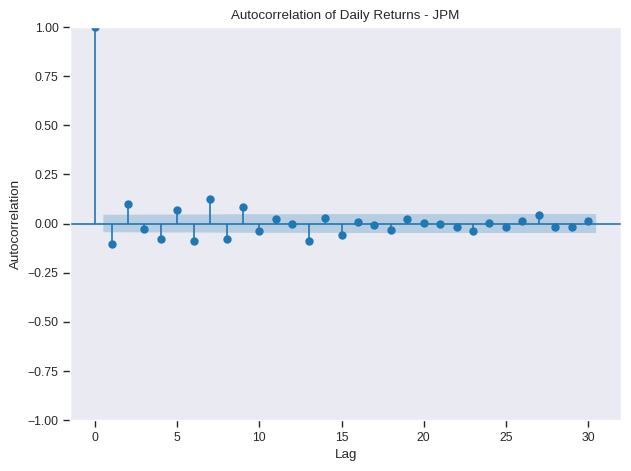

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
import os

returns = np.log(close / close.shift(1))
returns_jpm = returns['JPM'].dropna()
os.makedirs("data", exist_ok=True)
returns_jpm.to_csv("data/returns.csv")

returns_loaded = pd.read_csv("data/returns.csv", index_col=0, parse_dates=True)

os.makedirs("figures", exist_ok=True)

plt.figure(figsize=(8, 5))
plot_acf(returns_loaded, lags=30)
plt.title("Autocorrelation of Daily Returns - JPM")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid()
plt.tight_layout()
plt.savefig("figures/autocorrelation_returns.pdf", dpi=300)
plt.show()


/tmp/ipython-input-1211238326.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rets[ticker].dropna(), label=ticker, shade=True)
/tmp/ipython-input-1211238326.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rets[ticker].dropna(), label=ticker, shade=True)
/tmp/ipython-input-1211238326.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rets[ticker].dropna(), label=ticker, shade=True)
/tmp/ipython-input-1211238326.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rets[ticker].dropna(), label=

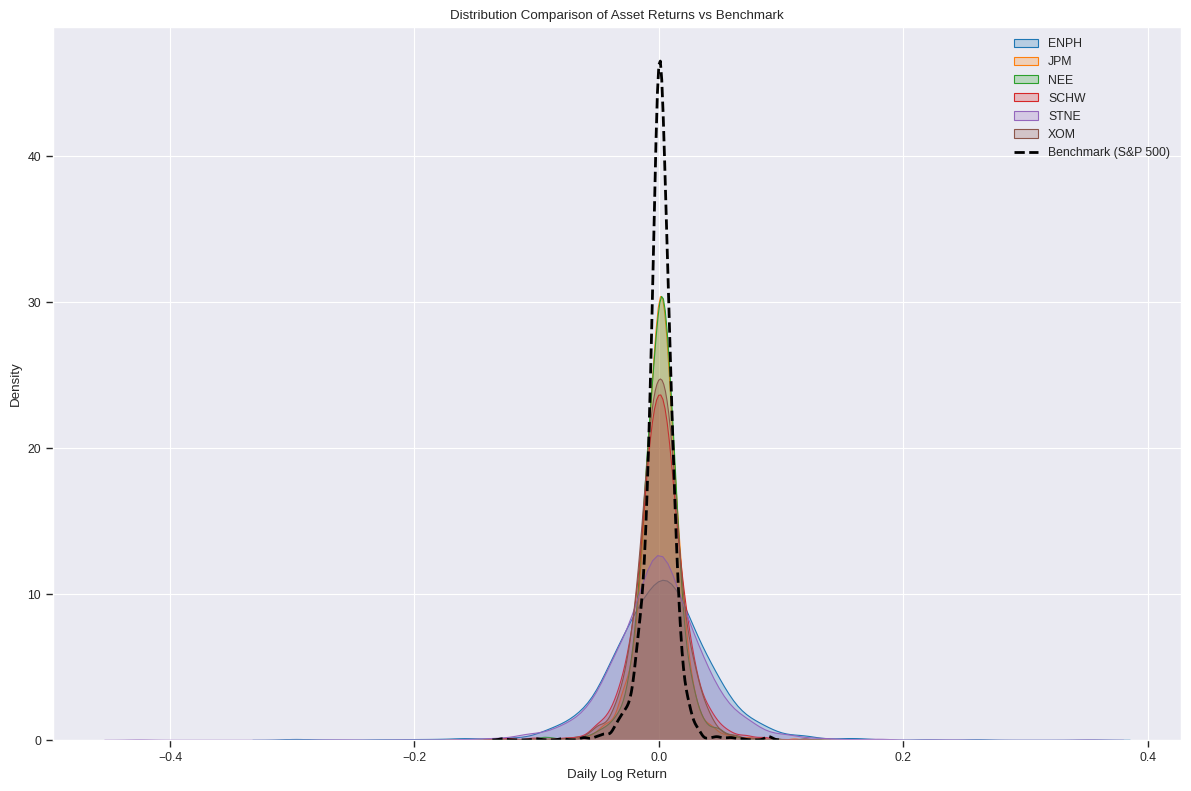

In [29]:
# Assume 'rets' is a DataFrame with daily log returns for each asset and the benchmark
tickers = ['ENPH', 'JPM', 'NEE', 'SCHW', 'STNE', 'XOM']  # Example tickers
benchmark = '^GSPC'  # Example benchmark (S&P 500)

plt.figure(figsize=(12, 8))
for ticker in tickers:
    sns.kdeplot(rets[ticker].dropna(), label=ticker, shade=True)
sns.kdeplot(rets[benchmark].dropna(), label='Benchmark (S&P 500)', color='black', linestyle='--', linewidth=2)
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.title("Distribution Comparison of Asset Returns vs Benchmark")
plt.legend()
plt.tight_layout()
plt.savefig("figures/distribution_comparison.pdf", dpi=300)
plt.show()

In [32]:
from google.colab import files

files.download('closing_prices.pdf')
files.download('normalized_prices.pdf')
files.download('risk_return_scatter.pdf')
files.download('return_distribution_jpm.pdf')
files.download('return_distribution_multiple.pdf')
files.download("rolling_volatility.pdf")
files.download("rolling_beta_multiple.pdf")
files.download("figures/autocorrelation_returns.pdf")
files.download("figures/distribution_comparison.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>